In [1]:
#Import necessary libraries - should work mostly from BCI_analysis + matplotlib + numpy
import BCI_analysis
from BCI_analysis.pipeline import pipeline_regression
import importlib
importlib.reload(pipeline_regression)
importlib.reload(BCI_analysis)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

No module named 'cellpose'
cannot use anatomical mode, but otherwise suite2p will run normally


[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 None,
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [2]:
#load multi-session mat files

#multisession_mat_file = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_new_old2.mat")
multisession_mat_file = os.path.abspath("/home/jupyter/temp/combined_new_old2.mat")
#multisession_mat_file_behavior = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/multi_session_mat/combined_behavior.mat")
multisession_mat_file_behavior = os.path.abspath("/home/jupyter/temp/combined_behavior.mat")

# print('loading multi-session imaging data...')
# multi_session_data = BCI_analysis.io_matlab.read_multisession_mat_2022(multisession_mat_file)
print('loading multi-session behavior data...')
multi_session_behavior_data = BCI_analysis.io_matlab.read_multisession_behavior_mat(multisession_mat_file_behavior)



loading multi-session behavior data...


In [3]:
# using data from .mat file 
from oasis.functions import deconvolve
importlib.reload(BCI_analysis)
dlc_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/DLC_output/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
suite2p_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/suite2p/Bergamo-2P-Photostim/")
sessionwise_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/sessionwise_tba/")
aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned/")
plt_save_path = os.path.abspath("/home/jupyter/Plots/")
face_rhythm_base_dir = '/home/jupyter/bucket/Data/Behavior_videos/FaceRhythm/'
motion_energy_base_dir = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/MotionEnergy/Bergamo-2P-Photostim/")
raw_video_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior_videos/raw/Bergamo-2P-Photostim/")

multi_session_dict = {'mouse':[],
                     'session':[],
                      'mat_idx':[],
                     'cn':[],
                     'DLC_aligned':[],
                     'F':[],
                     'trial_end_frames':[],
                     'F_original':[],
                     'trial_start_original':[],
                     'reward_original':[]}
needed_subject = 'BCI34'
do_deconvolve = True
convolve_movement_data = True
if convolve_movement_data:
    aligned_data_path = os.path.abspath("/home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/")
    convolve_tau = 0.7
else:
    convolve_tau = 0
for mat_session_index in range(len(multi_session_behavior_data['session'])):
    # if multi_session_behavior_data['mouse'][mat_session_index] != needed_subject:
    #     continue
    # try:
    try:
        mouse = multi_session_behavior_data['mouse'][mat_session_index][:3]+'_'+multi_session_behavior_data['mouse'][mat_session_index][3:]
    except:
        print('mouse ID missing, skipping')
        continue
    session = multi_session_behavior_data['session'][mat_session_index]
    camera = "side"
    data = {'F':multi_session_behavior_data['df_closedLoop'][mat_session_index].T,
           'trial_start':multi_session_behavior_data['trial_start'][mat_session_index],
           'reward':multi_session_behavior_data['rew'][mat_session_index],
           'cn':int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1,
           'si':multi_session_behavior_data['dt_si'][mat_session_index].tolist()}

    if do_deconvolve:
        spikes_matrix= []
        for F_trace in data['F']:
            c, s, b_, g_, lam = deconvolve(F_trace, penalty=1) 
            spikes_matrix.append(s)
        data['F'] = np.asarray(spikes_matrix)


    dict_aligned = BCI_analysis.pipeline_align.get_aligned_data(suite2p_path, 
                                                                dlc_base_dir, 
                                                                bpod_path, 
                                                                sessionwise_data_path, 
                                                                aligned_data_path, 
                                                                motion_energy_base_dir,
                                                                raw_video_path,
                                                                mouse=mouse, 
                                                                FOV=None, 
                                                                camera=camera, 
                                                                session=session, 
                                                                sampling='down', 
                                                                functions = ['diff','diff_signed','mean'],
                                                                function_window = 20,  ### important variable for downsampling 1 for facerhythm - 20/200 for DLC
                                                                convolve_tau = convolve_tau,#,0.7, #.7
                                                                plot = False,
                                                                overwrite=False,
                                                                use_provided_data=True,
                                                                add_motion_energy = False,
                                                                source_data = data,
                                                                face_rhythm_base_dir = face_rhythm_base_dir,
                                                                use_face_rhythm = False,
                                                                match_with_face_rhythm = False)
    DLC_aligned = pd.DataFrame.from_dict(dict_aligned['DLC_aligned'])
    F = np.concatenate(dict_aligned['F_aligned'], axis=1)

    multi_session_dict['mouse'].append(multi_session_behavior_data['mouse'][mat_session_index])
    multi_session_dict['session'].append(multi_session_behavior_data['session'][mat_session_index])
    multi_session_dict['cn'].append(int(multi_session_behavior_data['conditioned_neuron'][mat_session_index].tolist())-1)
    multi_session_dict['mat_idx'].append(mat_session_index)
    multi_session_dict['DLC_aligned'].append(DLC_aligned)
    multi_session_dict['F'].append(F)
    multi_session_dict['trial_end_frames'].append(dict_aligned['trial_start_indices'])
    multi_session_dict['F_original'].append(data['F'])
    multi_session_dict['trial_start_original'].append(data['trial_start'])
    multi_session_dict['reward_original'].append(data['reward'])
    #break
        
        
    # except:
    #     print('no luck with session {}'.format(mat_session_index))


    
    
    
print(dict_aligned.keys())



/home/jupyter/Scripts/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/BCI_33/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/BCI_33/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/BCI_33/062922-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/BCI_33/063022-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/BCI_33/070122-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/BCI_34/062722-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/BCI_34/062822-dict_aligned-downsampled.npy
File found at /home/jupyter/bucket/Data/Calcium_imaging/data_aligned_convolved/BCI_34/062922-dict_aligned-downsampled.npy
File found at /home/jupy

(156,)

In [32]:
real_deltas.shape

(156,)

/tmp/ipykernel_15837/4290166359.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = [10,10])


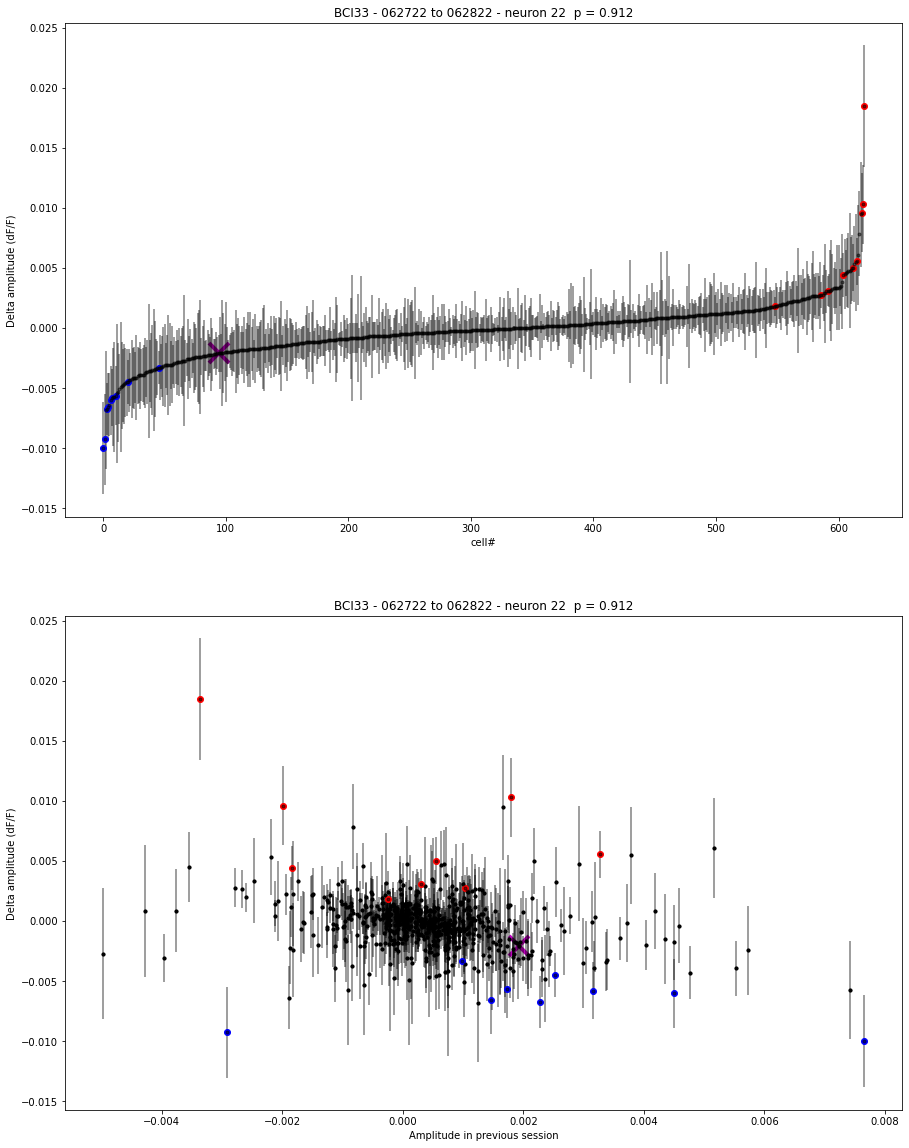

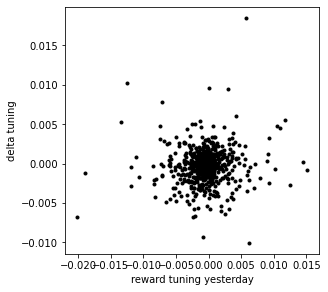

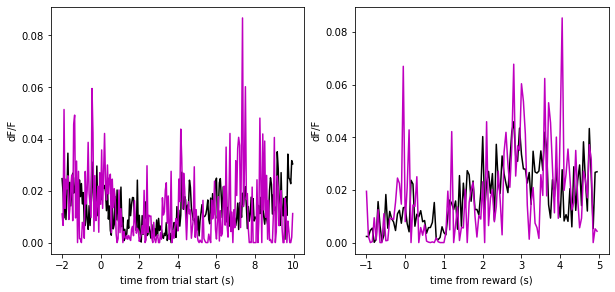

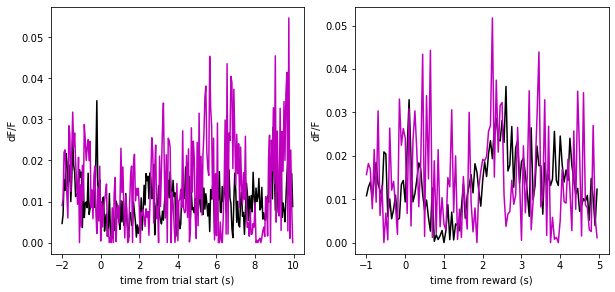

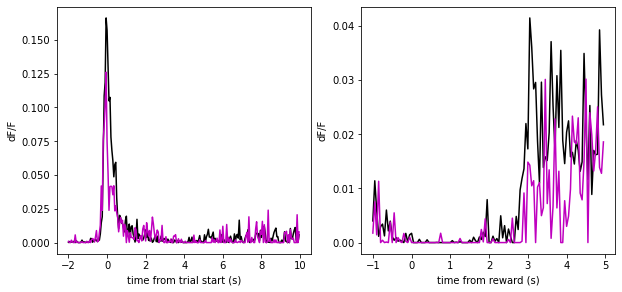

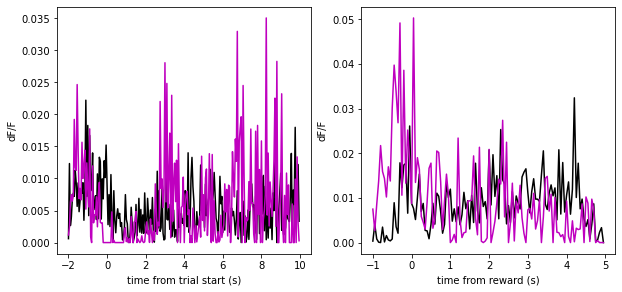

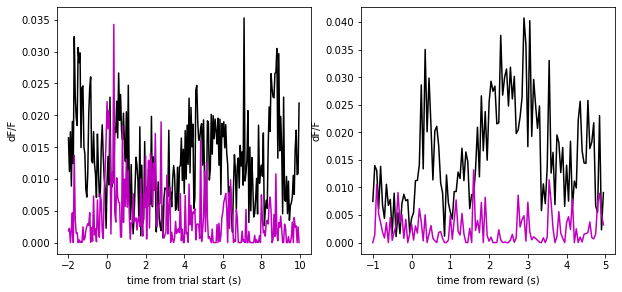

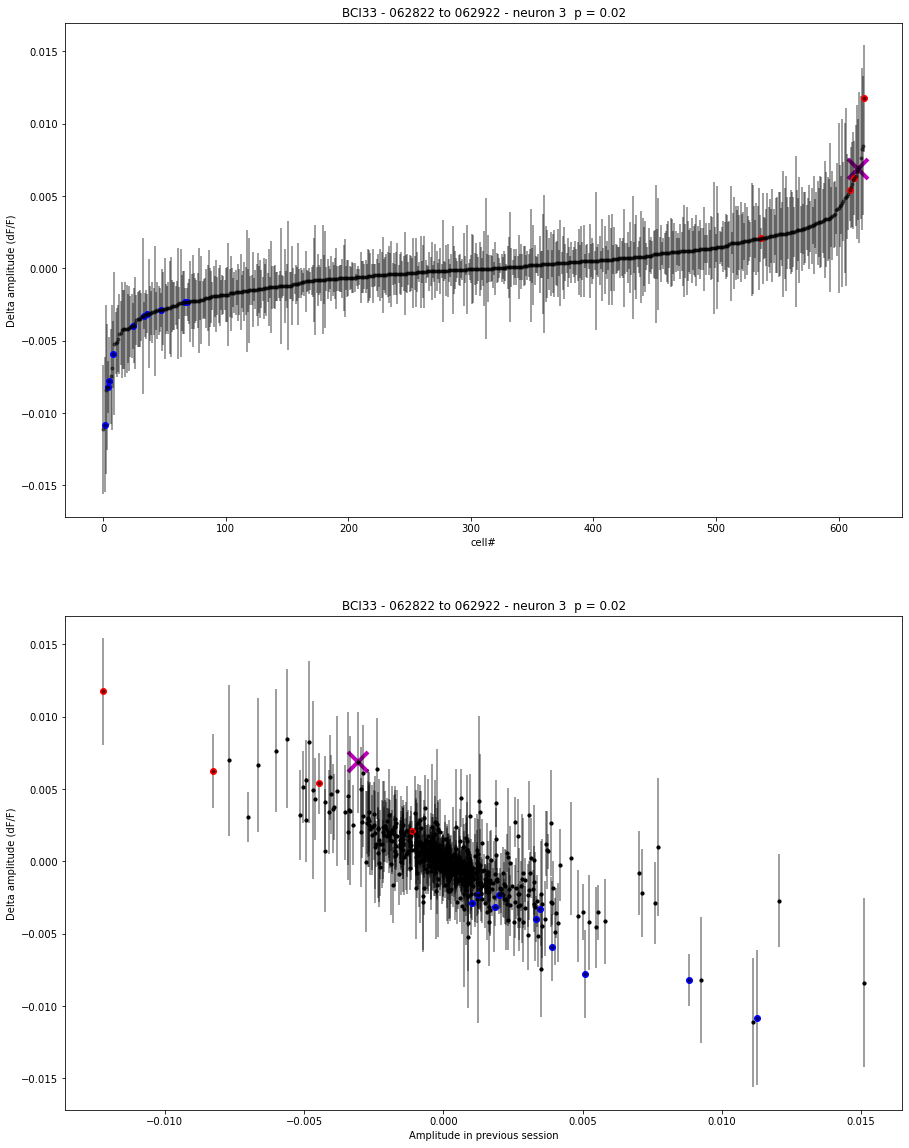

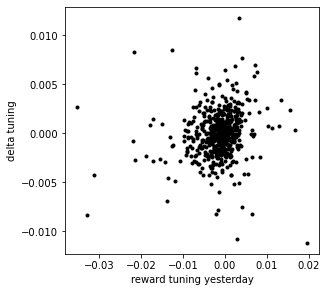

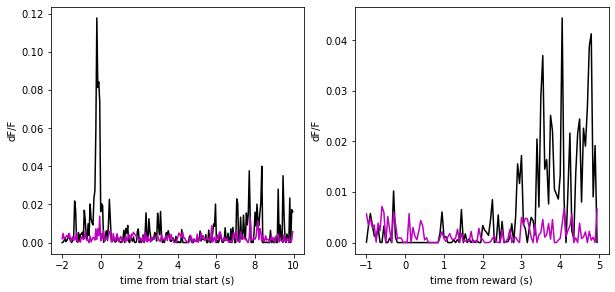

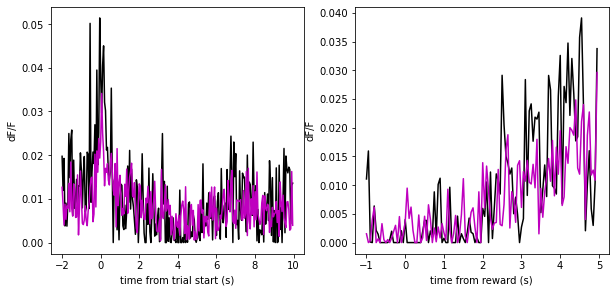

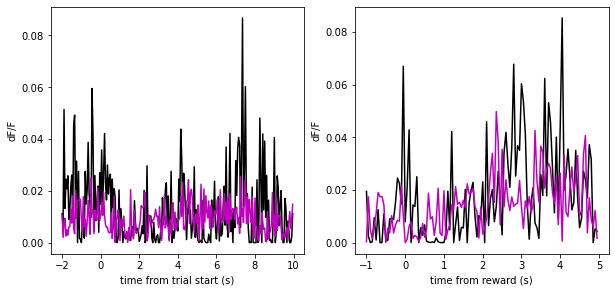

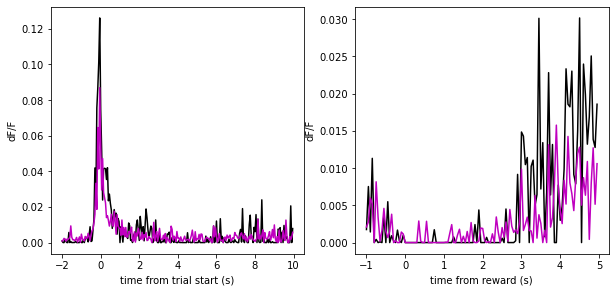

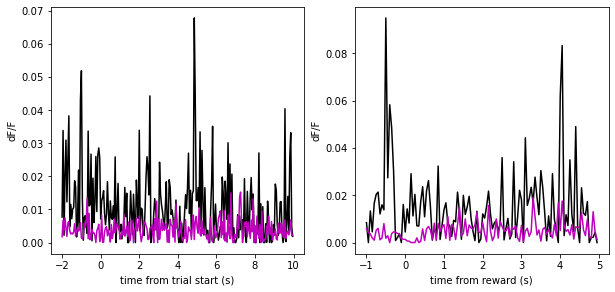

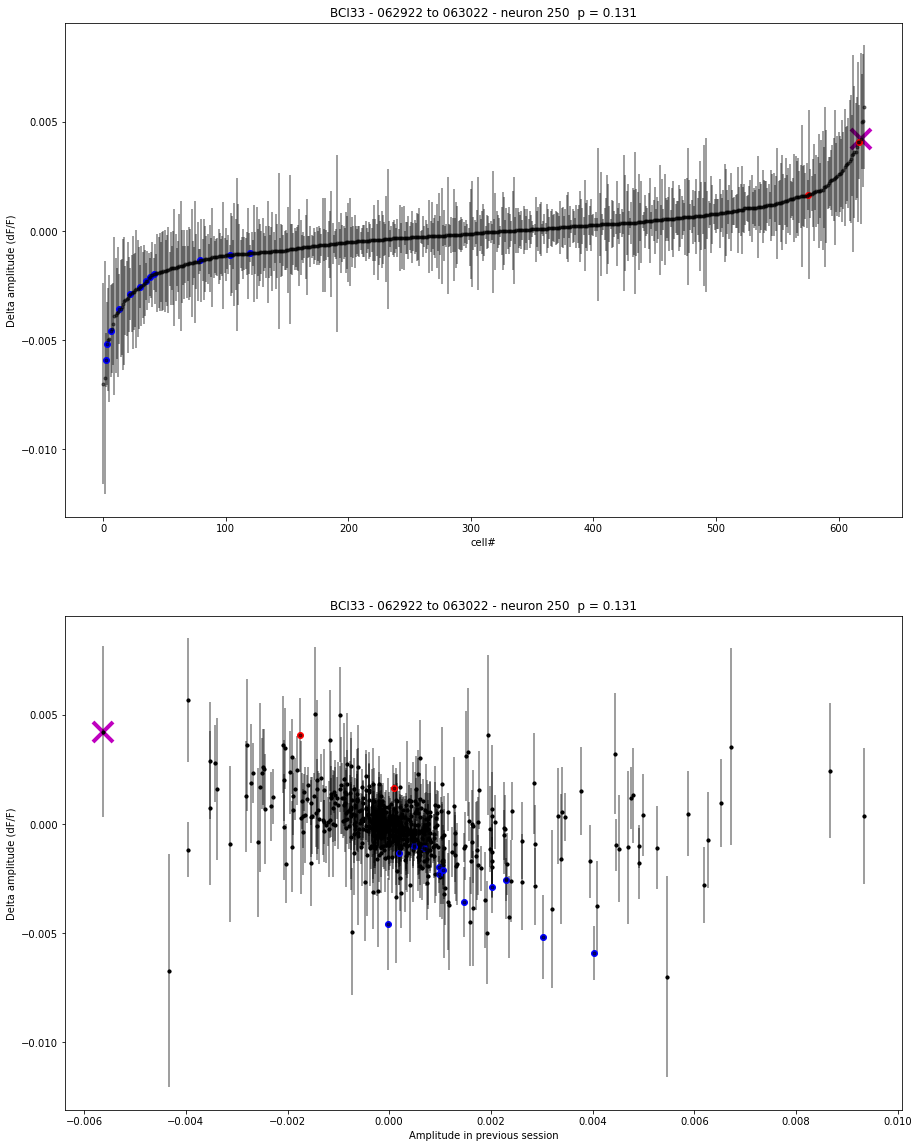

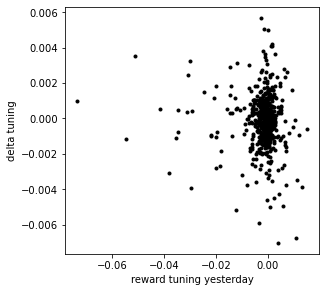

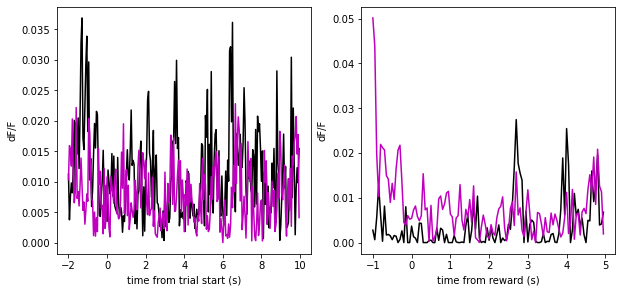

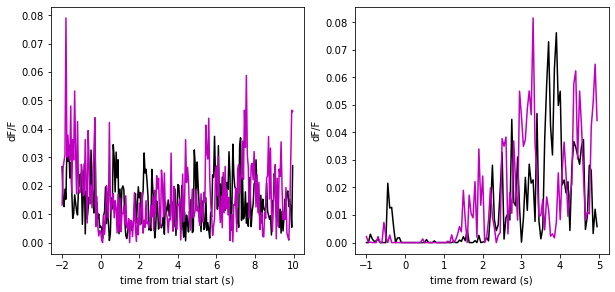

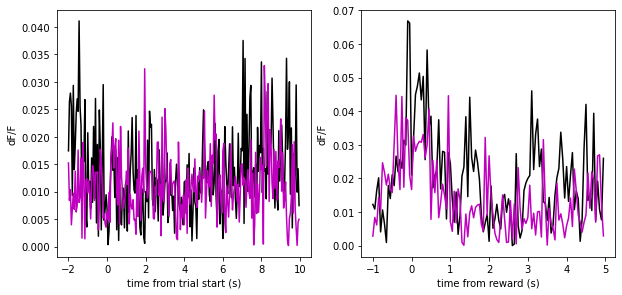

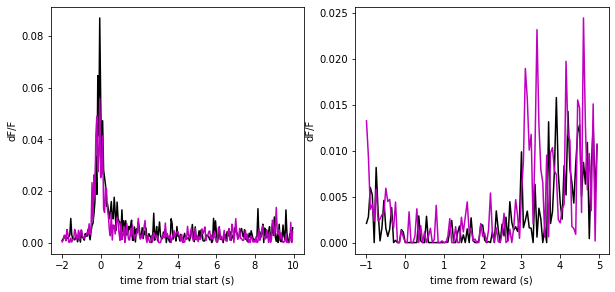

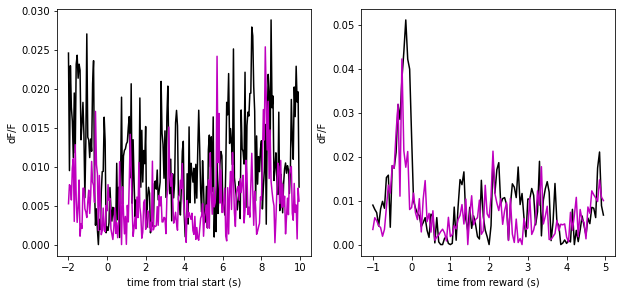

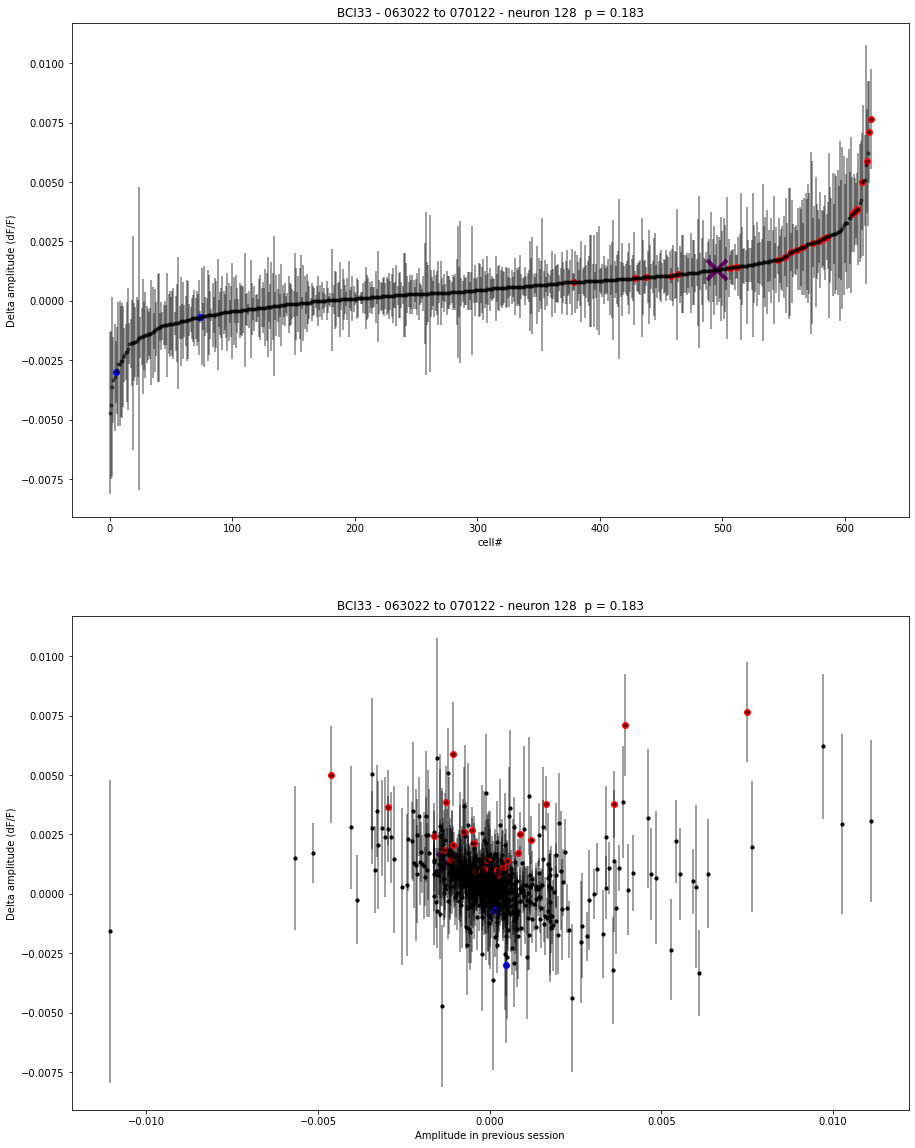

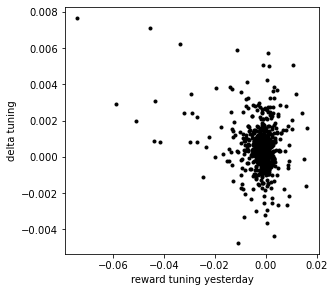

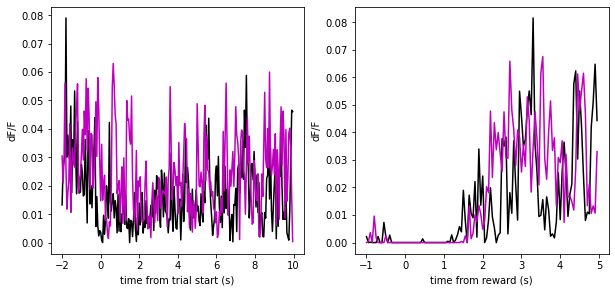

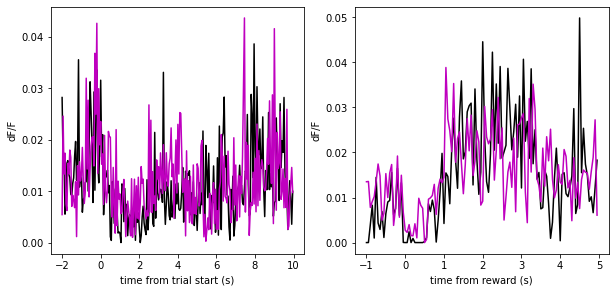

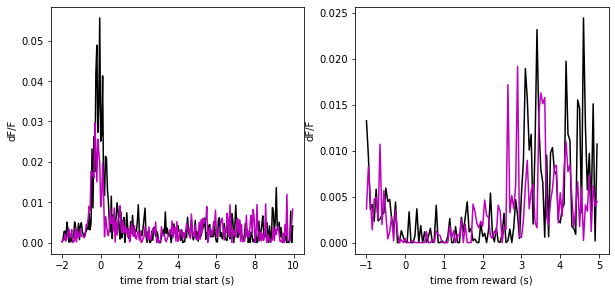

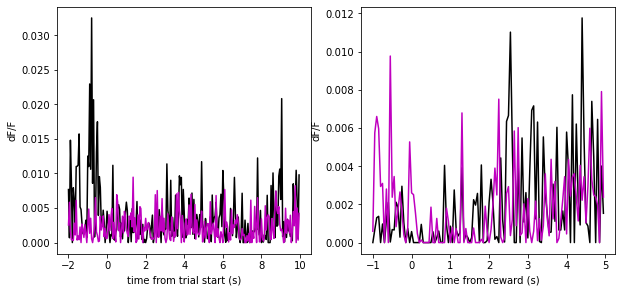

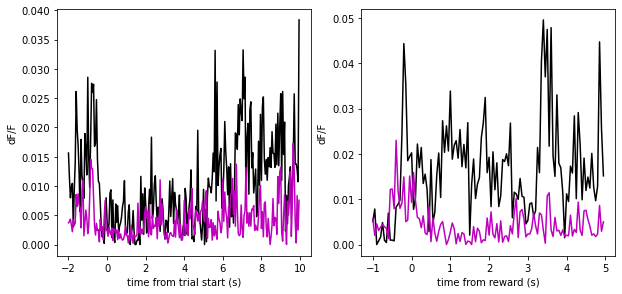

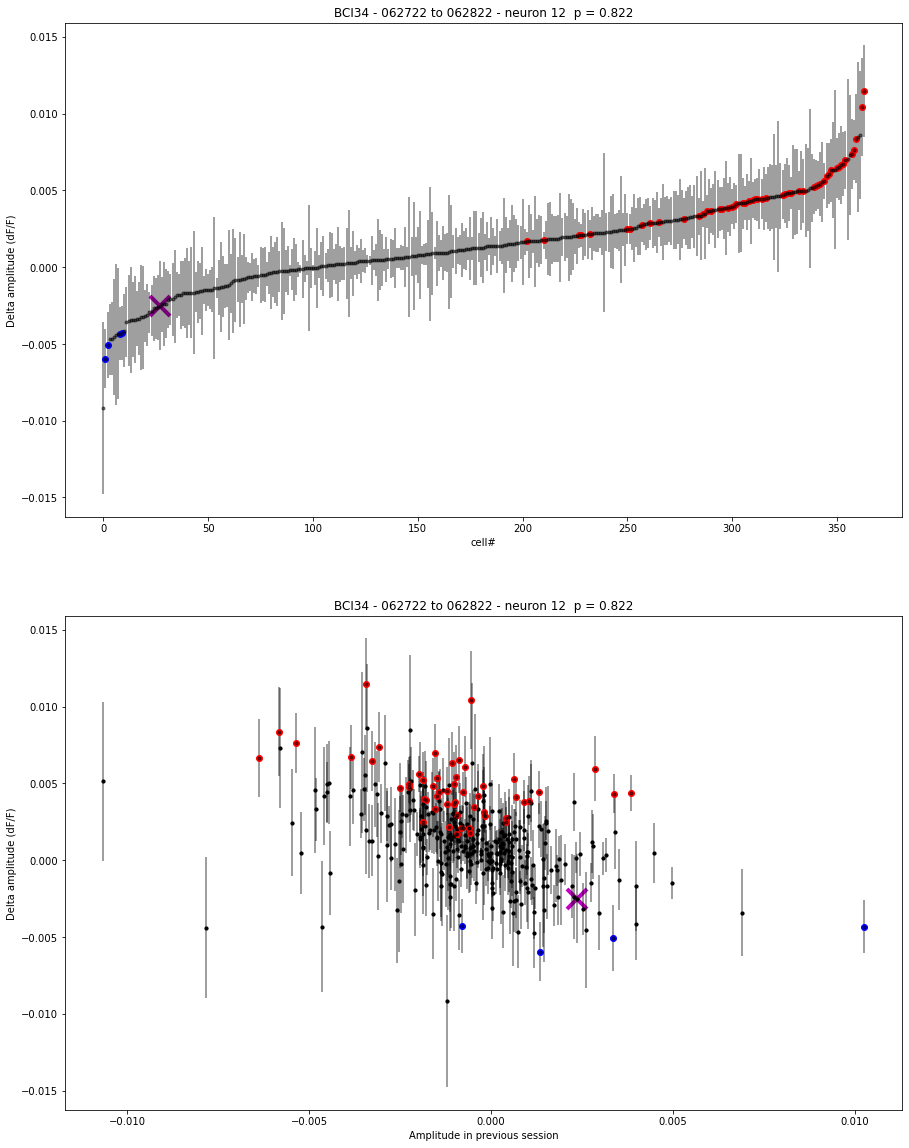

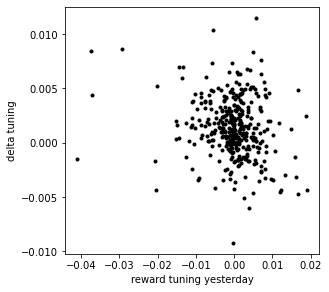

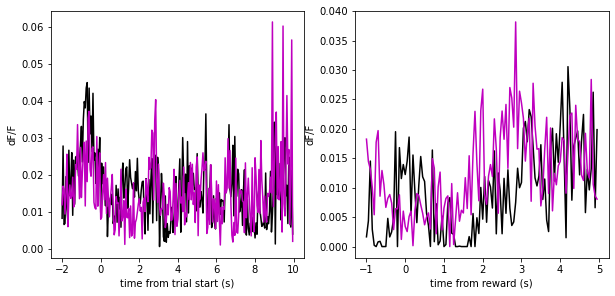

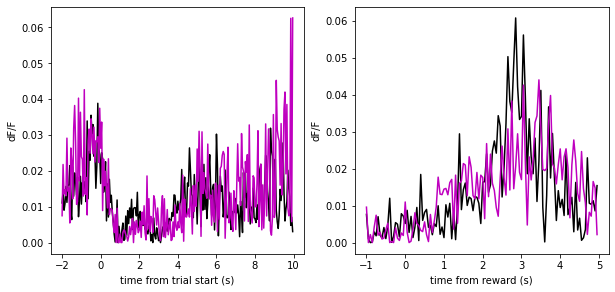

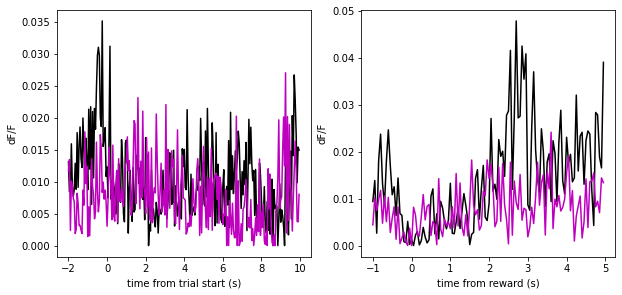

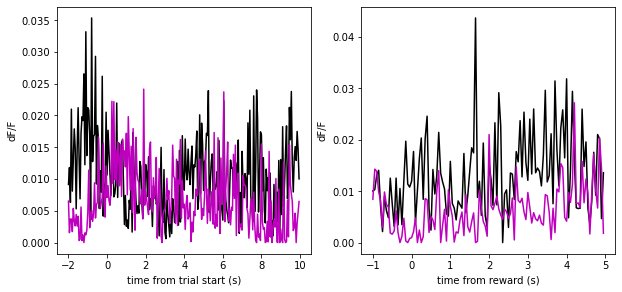

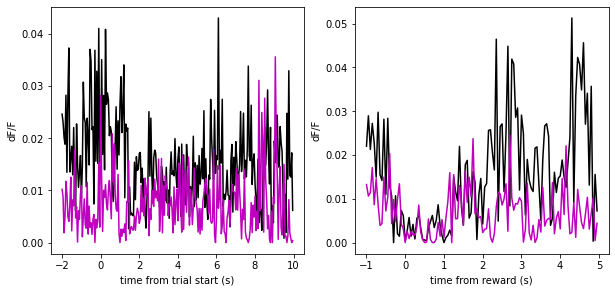

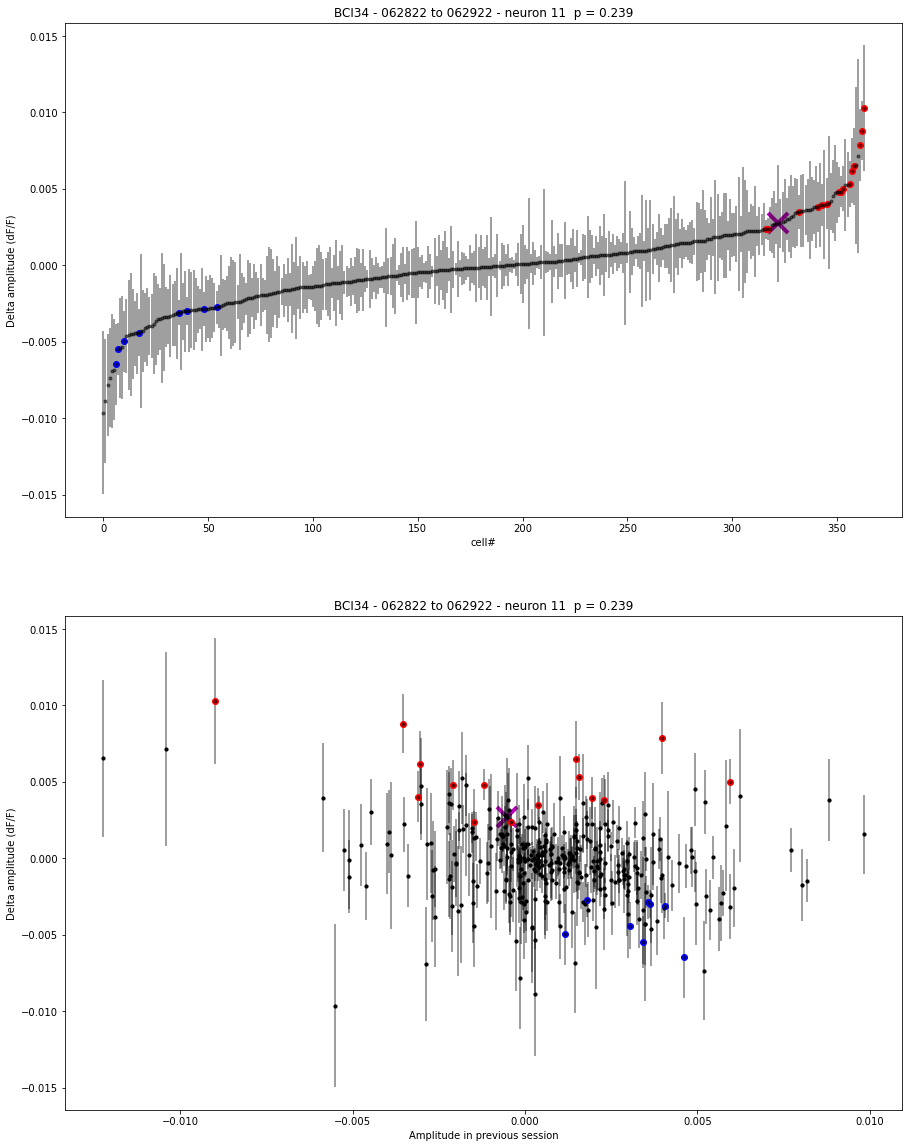

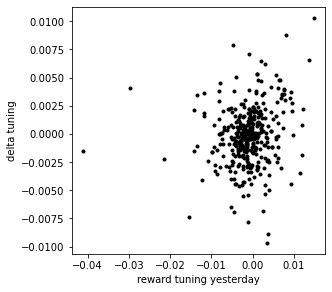

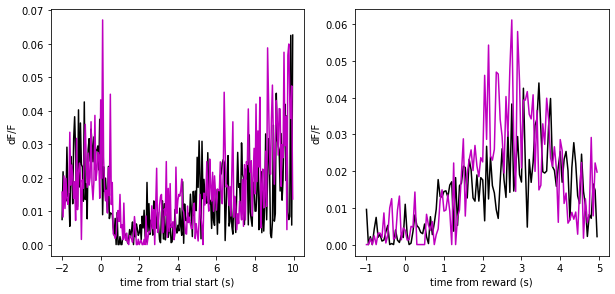

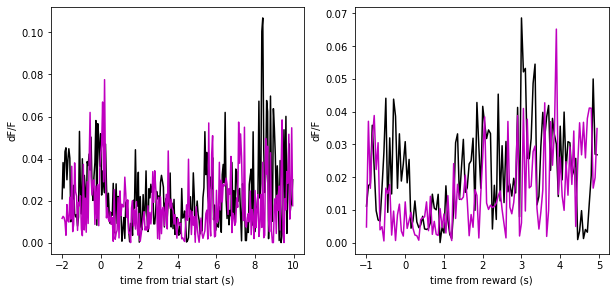

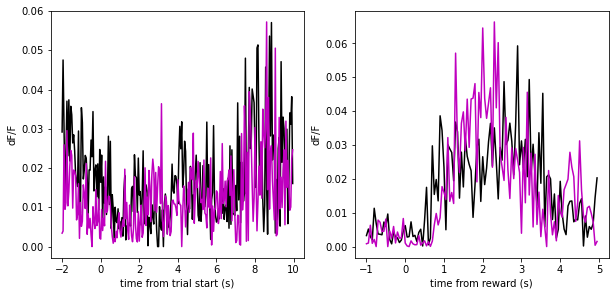

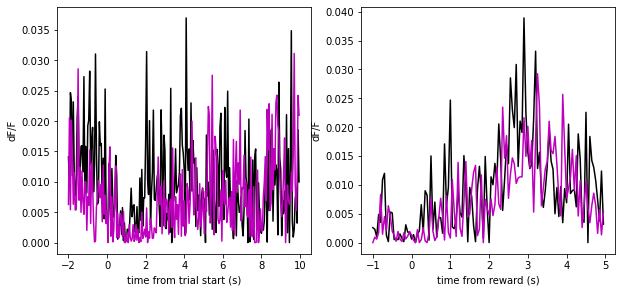

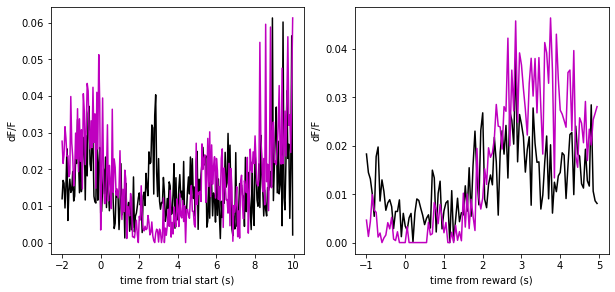

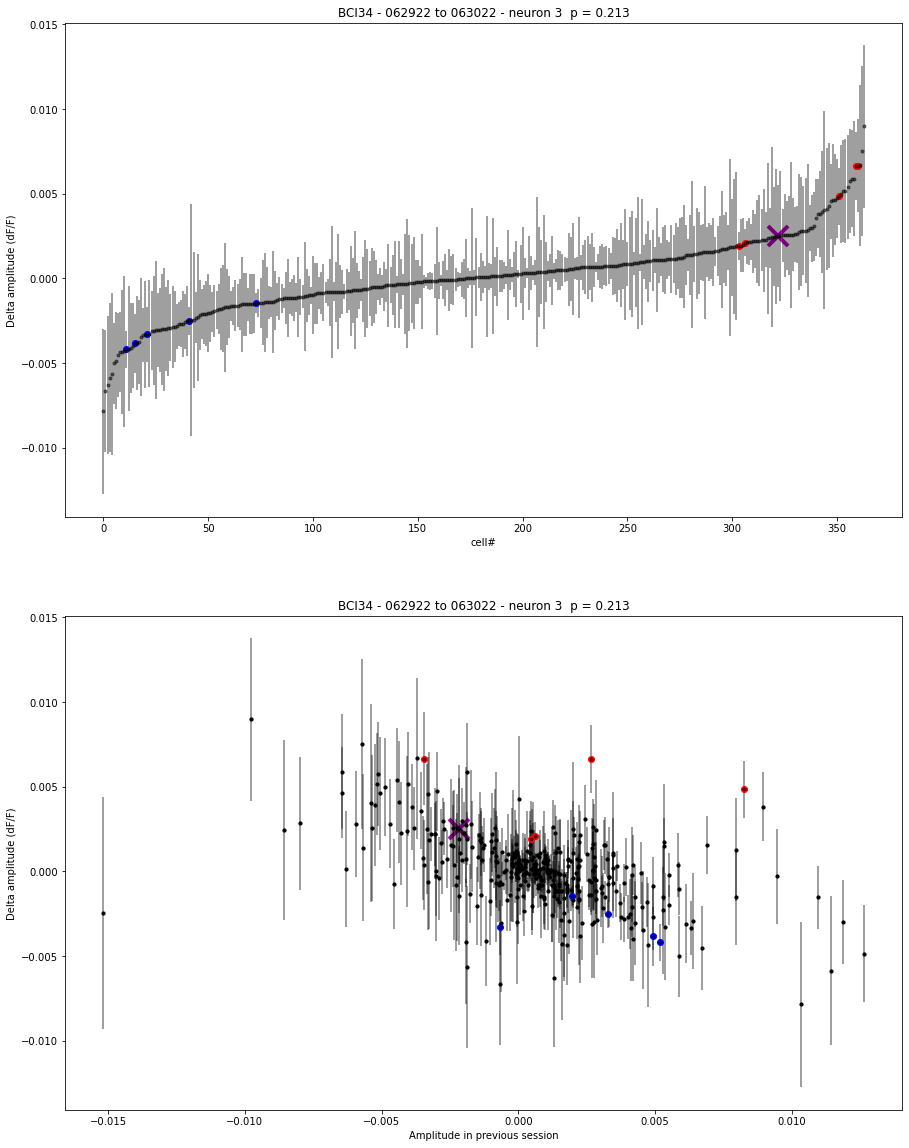

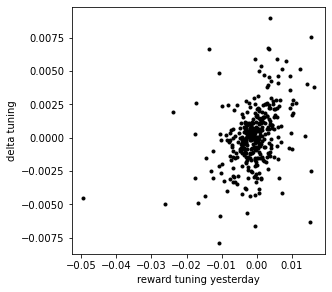

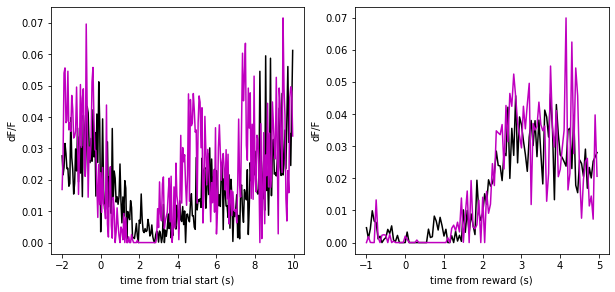

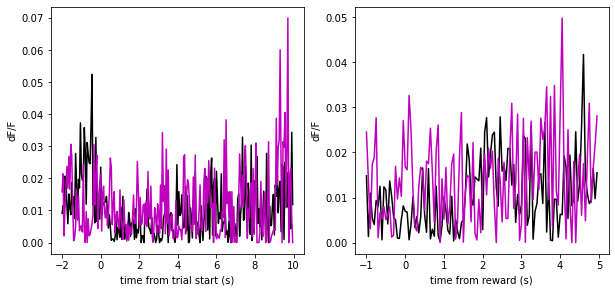

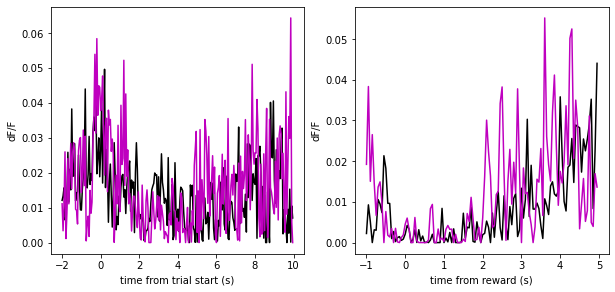

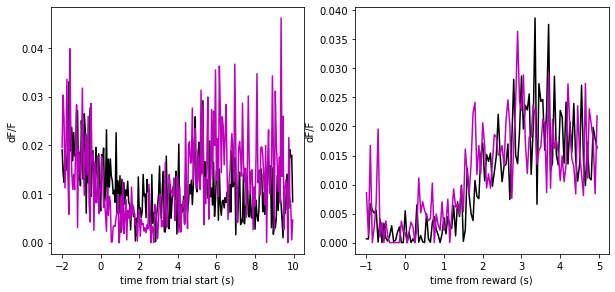

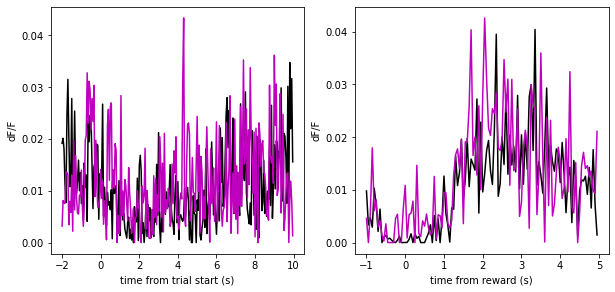

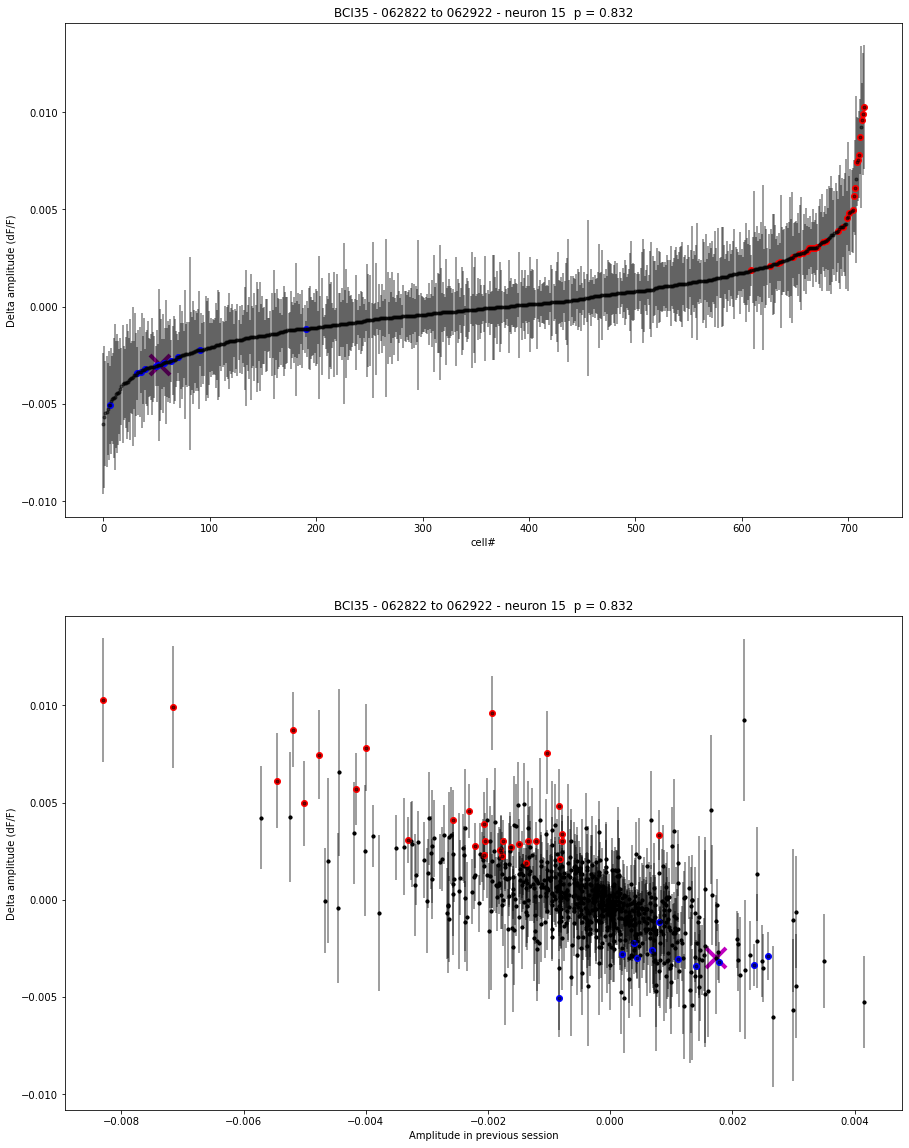

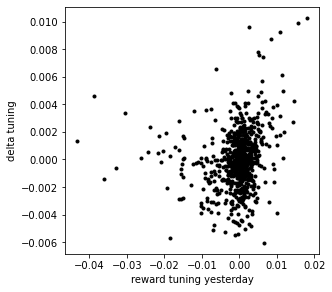

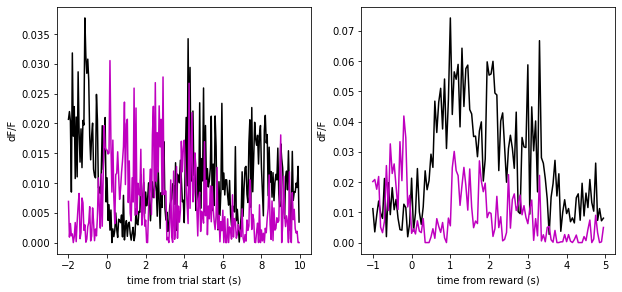

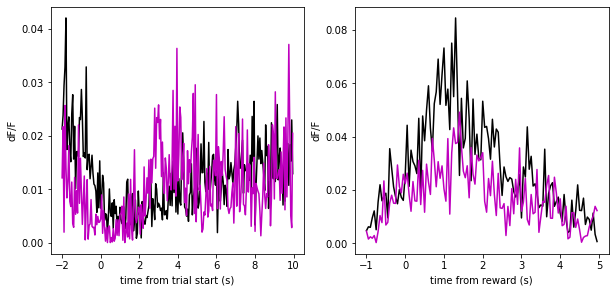

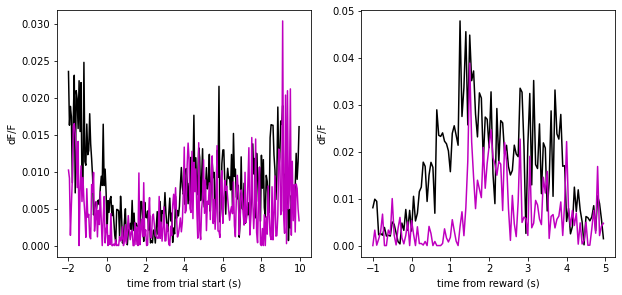

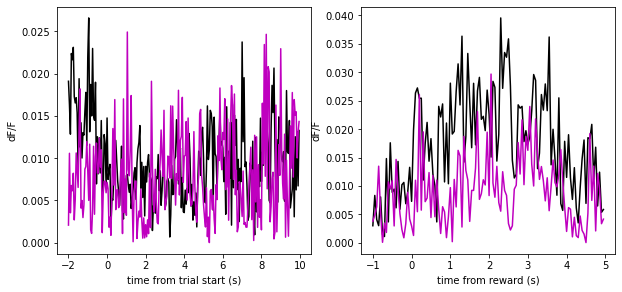

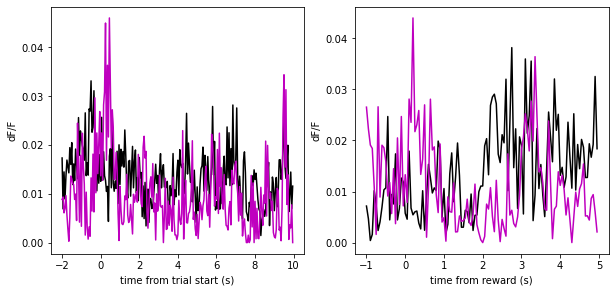

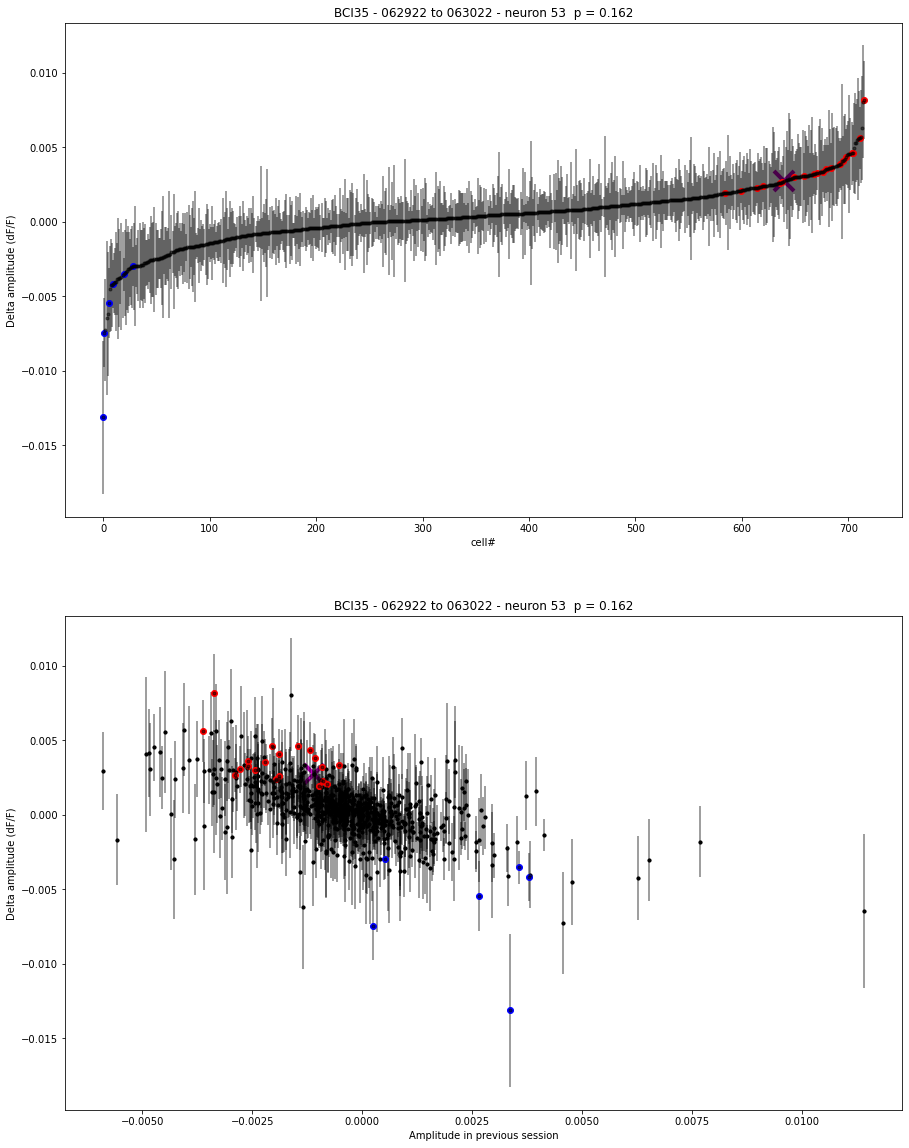

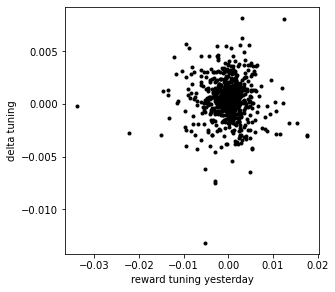

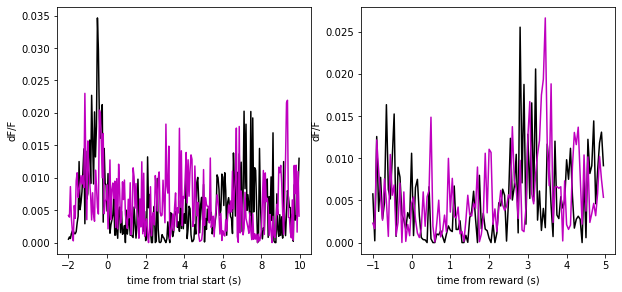

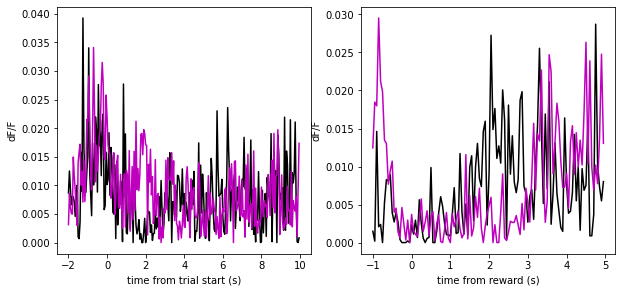

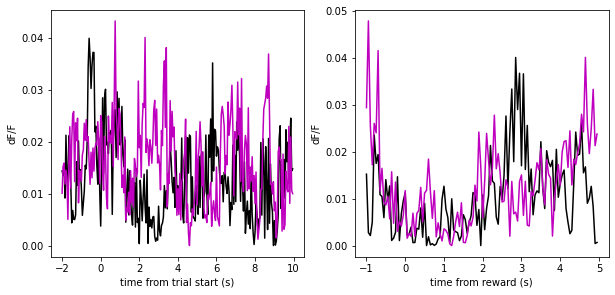

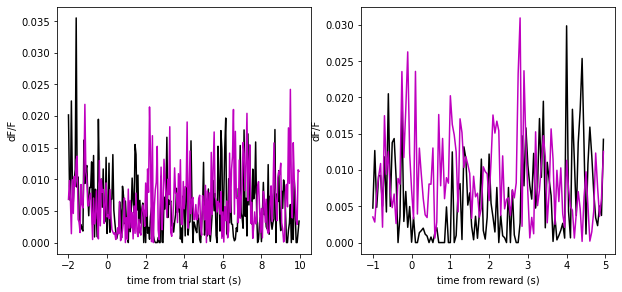

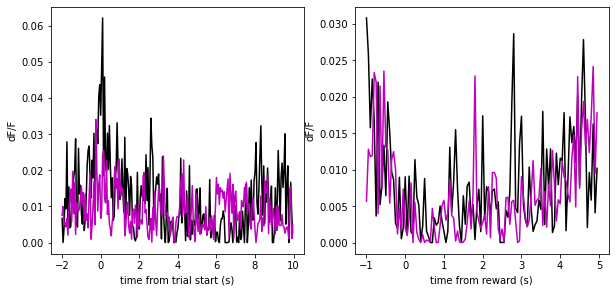

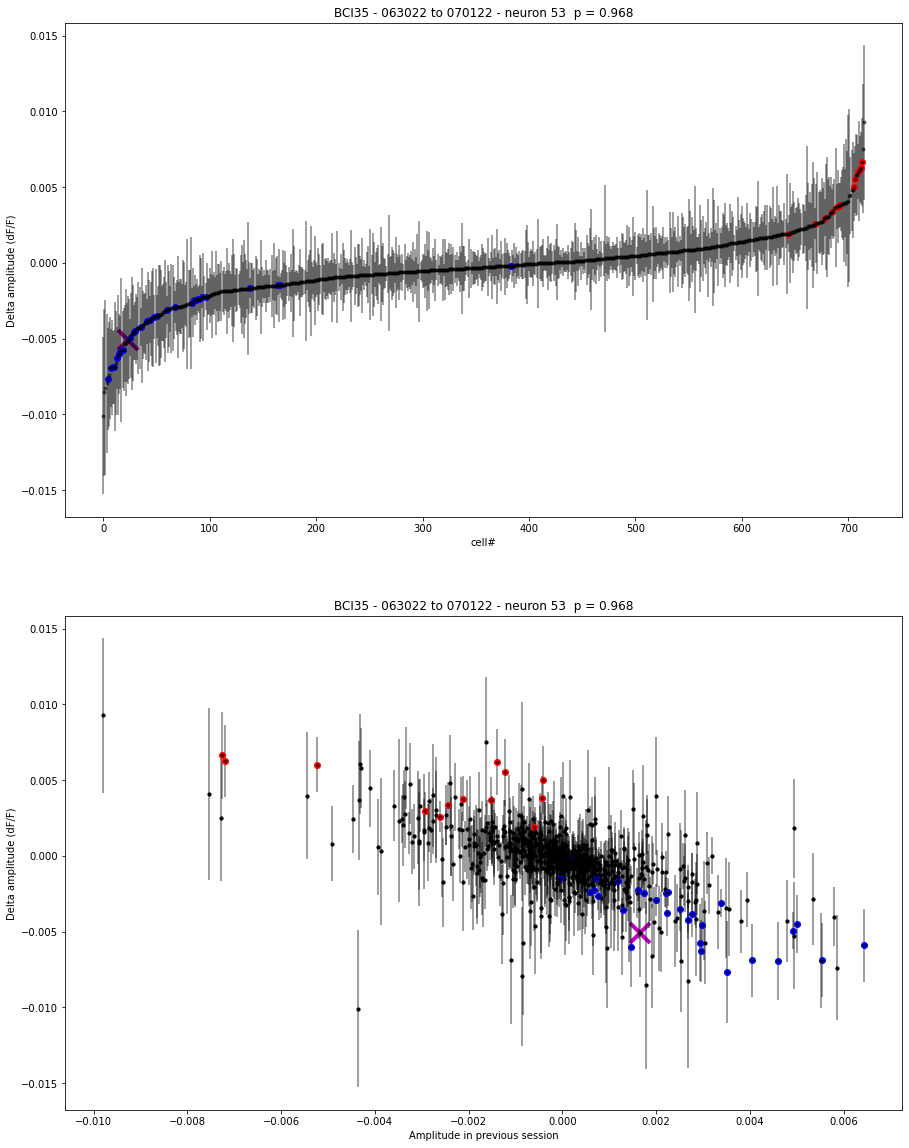

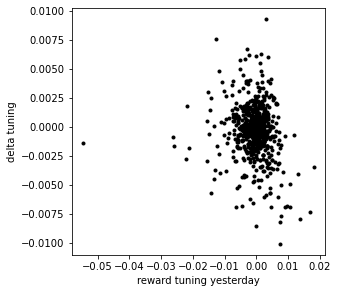

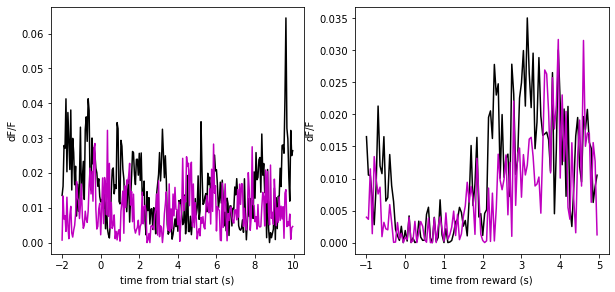

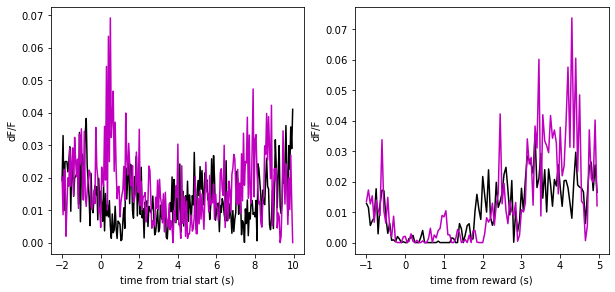

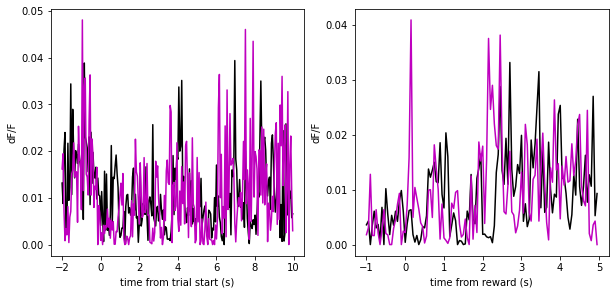

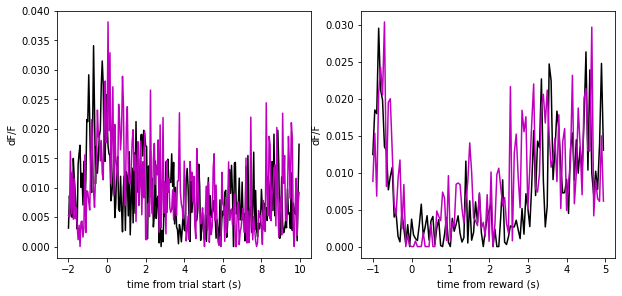

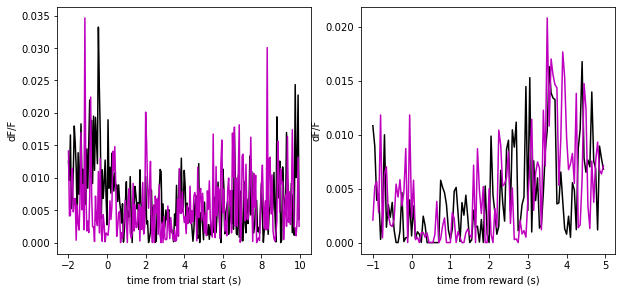

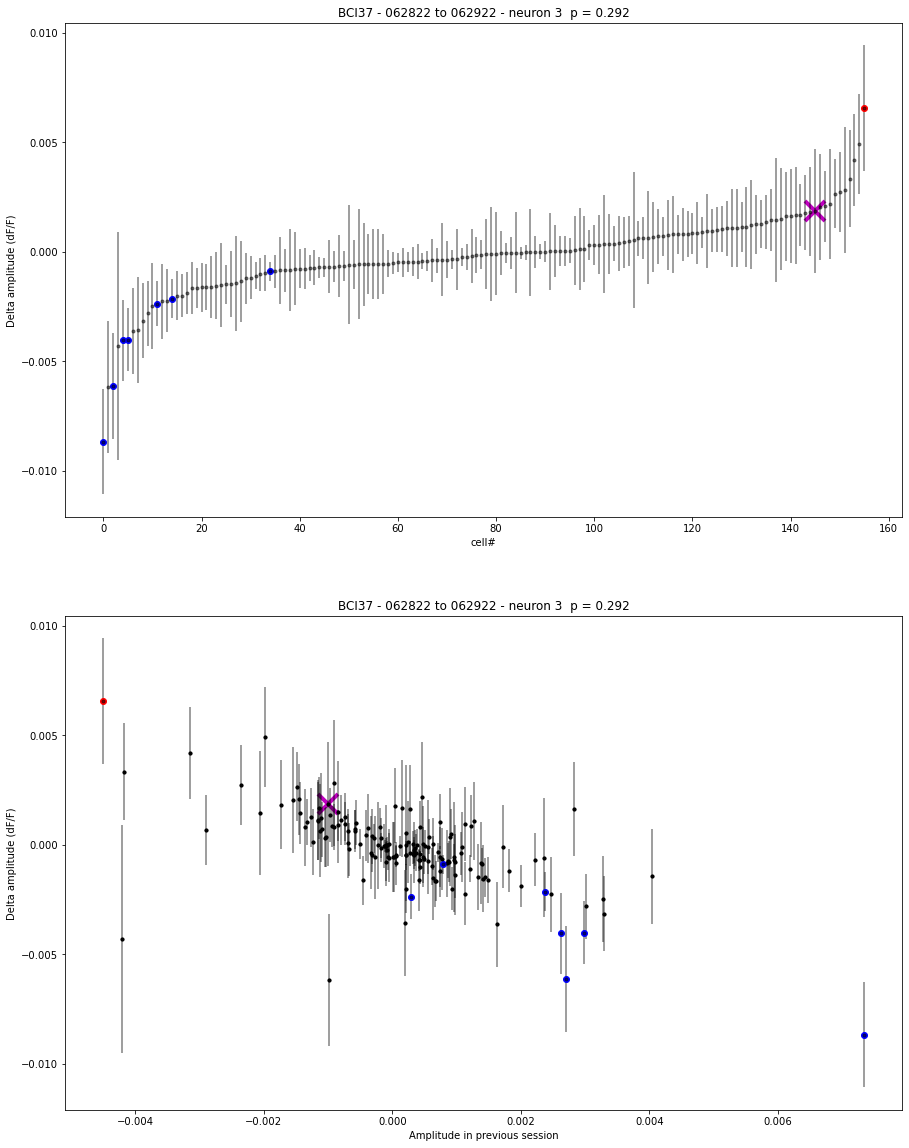

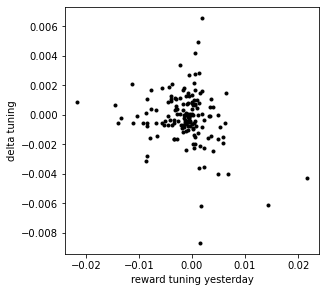

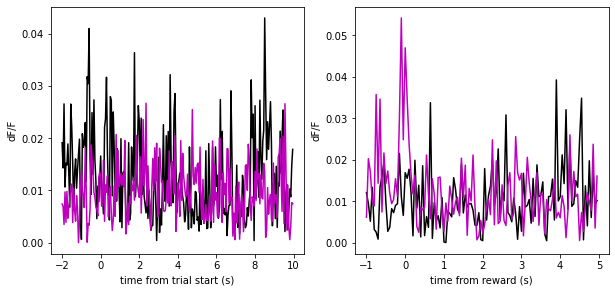

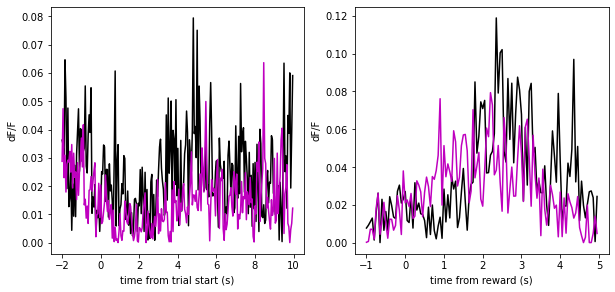

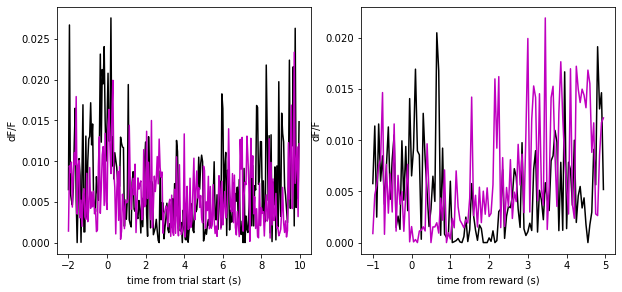

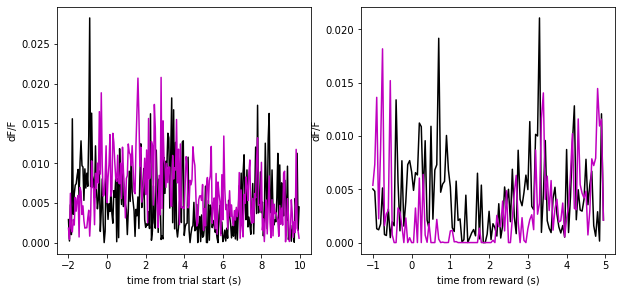

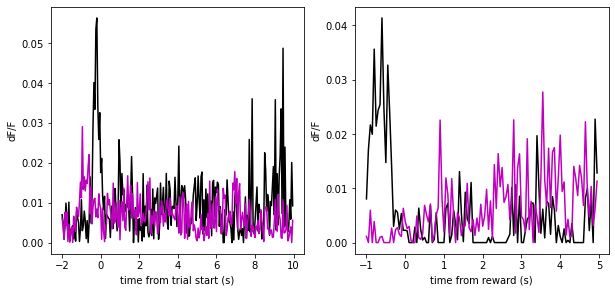

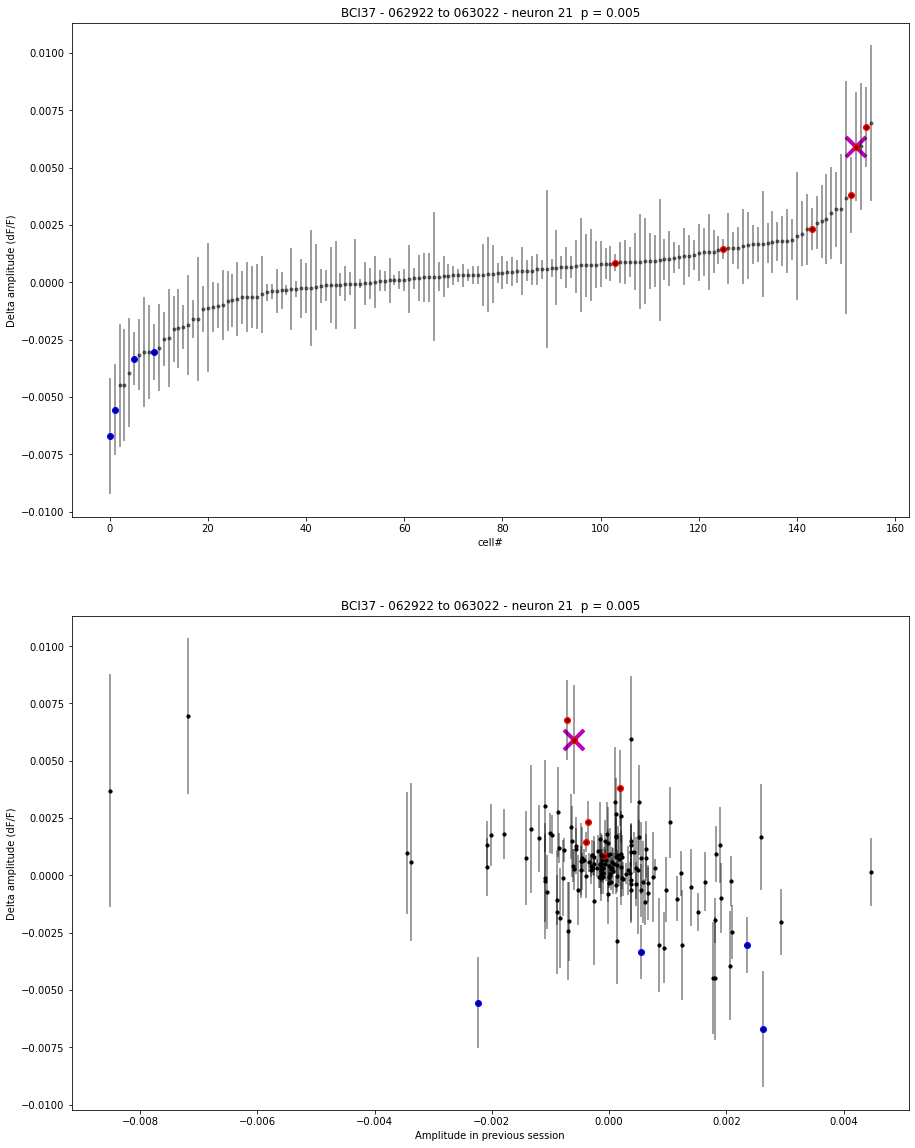

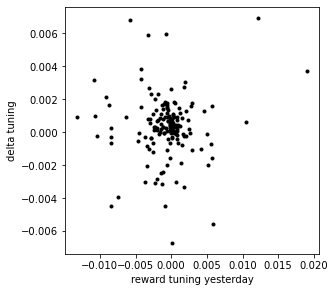

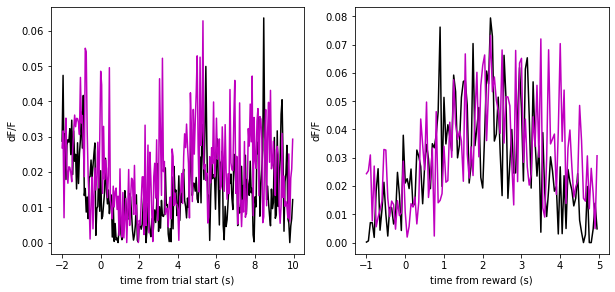

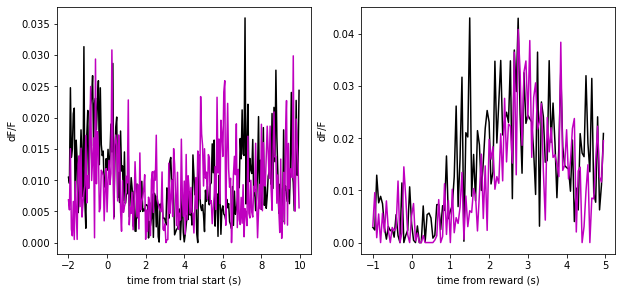

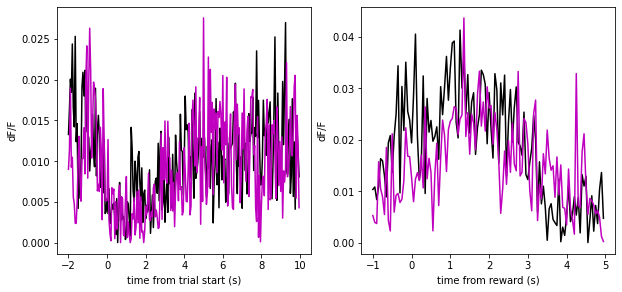

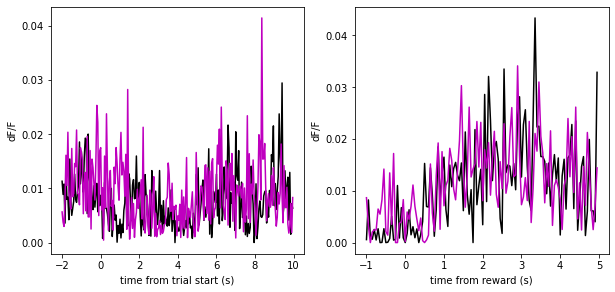

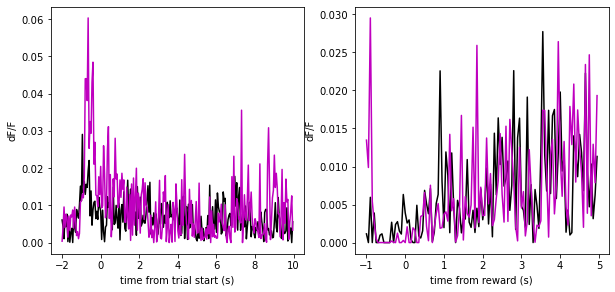

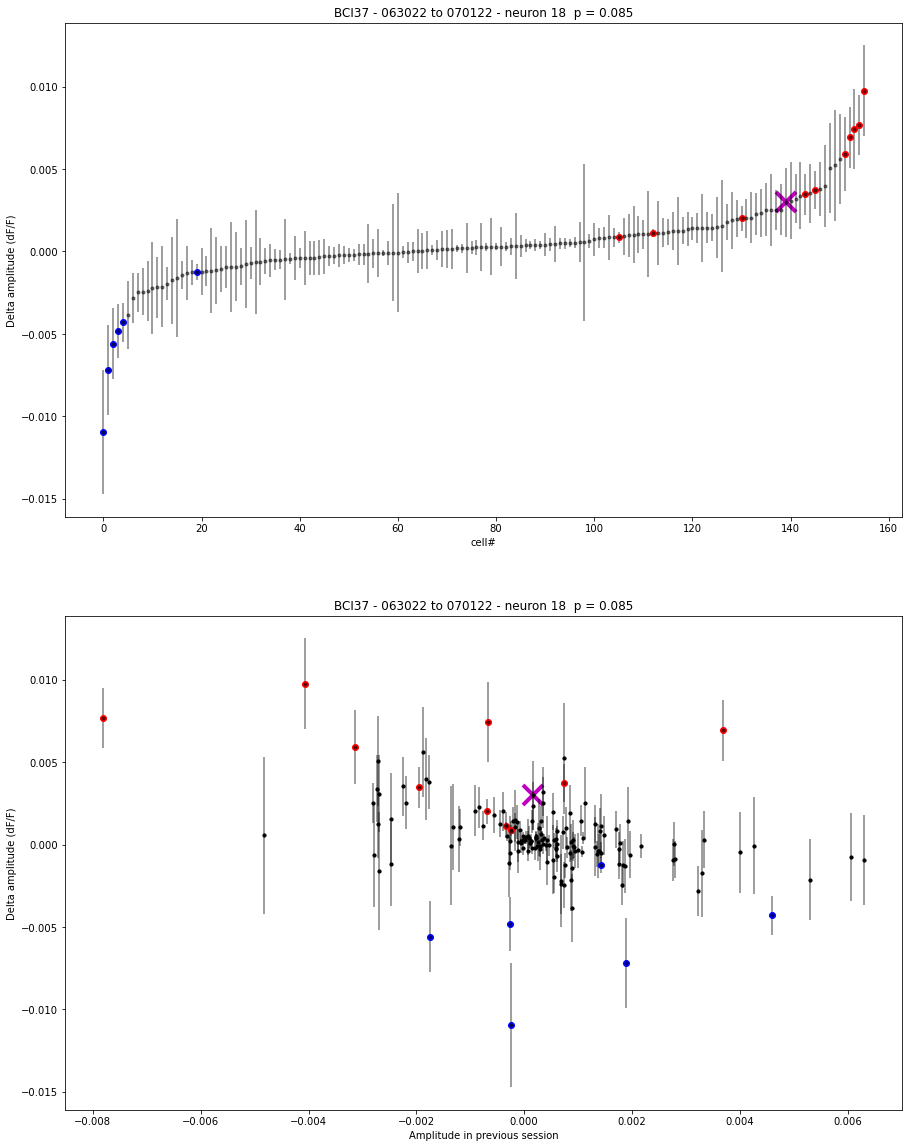

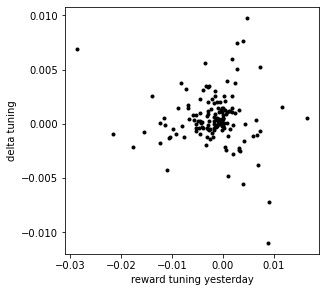

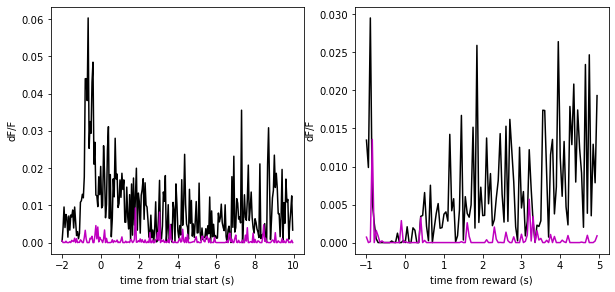

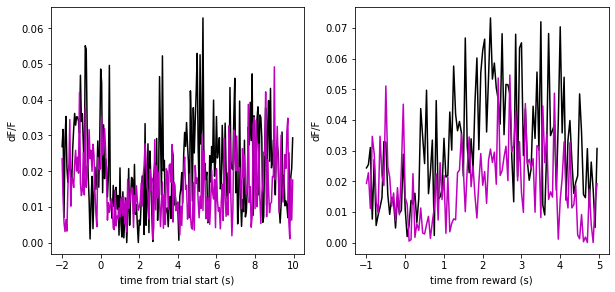

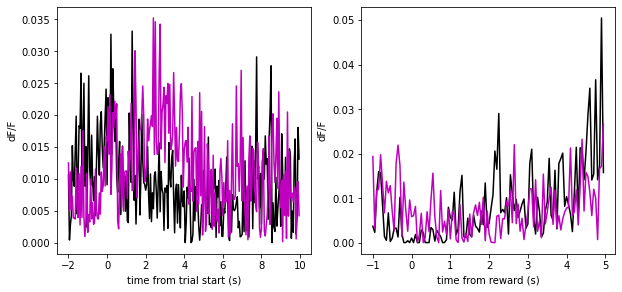

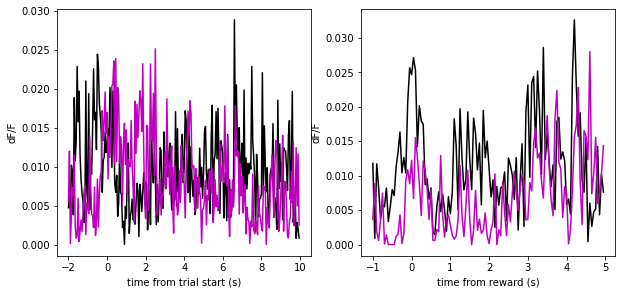

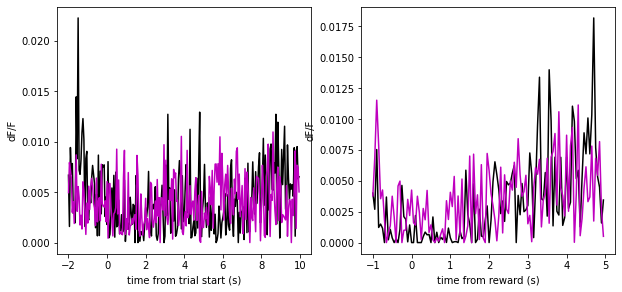

In [10]:
# bootstrapping of amplitudes 
# incidentally, look at the most negatively tuned cells
from sklearn.utils import resample
plot_amplitudes = True
max_p = .01
n_bootstrap = 1000
step_back = 40 #baseline before trial start (in frames)
step_forward = 200 #integration time after trial start (frames)
step_back_reward = 20 #baseline before trial start (in frames)
step_forward_reward = 100 #integration time after trial start (frames)
trace_time = np.arange(-step_back,step_forward)/20
trace_time_reward = np.arange(-step_back_reward,step_forward_reward)/20
# check if CNs are really increasing it's activity - who are the other cells that increase their activity
multi_session_dict['F_trialwise'] = [] #time x neuron x trial
multi_session_dict['F_rewardwise'] = [] #time x neuron x trial
multi_session_dict['amplitude'] = []
multi_session_dict['previous_amplitude'] = []
multi_session_dict['delta_amplitude'] = []
multi_session_dict['p_increase'] = []
multi_session_dict['p_decrease'] = []
for session_i,session in enumerate(multi_session_dict['session']):
    # trial_start_trace = np.zeros(multi_session_dict['F'][session_i].shape[1])
    # trial_start_trace[np.concatenate([[0],multi_session_dict['trial_end_frames'][session_i][:-1]])] = 1
    trial_start_trace = multi_session_dict['trial_start_original'][session_i]
    F_trialwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            trial_start_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward, 
                                                                            frames_before=step_back,
                                                                            include_next_trial=True)
    
    
    multi_session_dict['F_trialwise'].append(F_trialwise)
    
    
    reward_trace = multi_session_dict['reward_original'][session_i]
    F_rewardwise = BCI_analysis.io_suite2p.sessionwise_to_trialwise_simple(multi_session_dict['F_original'][session_i],
                                                                            reward_trace,
                                                                            max_frames=None,
                                                                            frames_after=step_forward_reward, 
                                                                            frames_before=step_back_reward,
                                                                            include_next_trial=True)
    
    
    multi_session_dict['F_rewardwise'].append(F_rewardwise)
    
    if session_i >0:
        if multi_session_dict['F'][session_i].shape[0] == multi_session_dict['F'][session_i-1].shape[0]: #there is a previous session
           
            now_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i][:step_back,:,1:],0))
            prev_amplitudes = (np.nanmean(multi_session_dict['F_trialwise'][session_i-1][step_back:,:,1:],0) - np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:step_back,:,1:],0))
            now_reward_amplitudes = (np.nanmean(multi_session_dict['F_rewardwise'][session_i][step_back_reward:,:,1:],0) - np.nanmean(multi_session_dict['F_rewardwise'][session_i][:step_back_reward,:,1:],0))
            prev_reward_amplitudes = (np.nanmean(multi_session_dict['F_rewardwise'][session_i-1][step_back_reward:,:,1:],0) - np.nanmean(multi_session_dict['F_rewardwise'][session_i-1][:step_back_reward,:,1:],0))
            real_deltas = np.nanmean(now_amplitudes,1)-np.nanmean(prev_amplitudes,1)
            cn = multi_session_dict['cn'][session_i]

            
            prev_mean_amplitude_bootstrap_list = []
            now_mean_amplitude_bootstrap_list = []

            for bootstrap_i in range(n_bootstrap):
                now_indices = resample(np.arange(now_amplitudes.shape[1]))
                now_mean_amplitude_bootstrap_list.append(np.mean(now_amplitudes[:,now_indices],1))
                prev_indices = resample(np.arange(prev_amplitudes.shape[1]))
                prev_mean_amplitude_bootstrap_list.append(np.mean(prev_amplitudes[:,prev_indices],1))
            now_mean_amplitude_bootstrap_list = np.asarray(now_mean_amplitude_bootstrap_list)
            prev_mean_amplitude_bootstrap_list = np.asarray(prev_mean_amplitude_bootstrap_list)
            delta_amplitudes_bootstrap = now_mean_amplitude_bootstrap_list-prev_mean_amplitude_bootstrap_list
            delta_sd = np.std(delta_amplitudes_bootstrap,0)


            cell_order = np.argsort(real_deltas)
            significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cell_order]<max_p
            significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)[cell_order]<max_p
            
            multi_session_dict['delta_amplitude'].append(real_deltas)
            multi_session_dict['p_increase'].append(1-np.nanmean(delta_amplitudes_bootstrap>0,0))
            multi_session_dict['p_decrease'].append(1-np.nanmean(delta_amplitudes_bootstrap<0,0))
            multi_session_dict['amplitude'].append(np.nanmean(now_amplitudes,1))
            multi_session_dict['previous_amplitude'].append(np.nanmean(prev_amplitudes,1))
            if plot_amplitudes:
                fig = plt.figure(figsize = [15,20])
                ax = fig.add_subplot(2,1,1)

                ax.plot(np.argmax(cell_order==cn),real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.errorbar(np.arange(len(cell_order)),real_deltas[cell_order],yerr = delta_sd[cell_order],fmt='.',color = 'black',alpha = .5)
                ax.plot(np.arange(len(cell_order))[significantly_increasing_indices],real_deltas[cell_order][significantly_increasing_indices],'ro')
                ax.plot(np.arange(len(cell_order))[significantly_decreasing_indices],real_deltas[cell_order][significantly_decreasing_indices],'bo')
                ax.set_xlabel('cell#')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))
                significantly_increasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap>0,0)<max_p
                significantly_decreasing_indices = 1-np.nanmean(delta_amplitudes_bootstrap<0,0)<max_p
                #now_ampls = sklearn.utils.resample(now_amplitudes)

                ax = fig.add_subplot(2,1,2)
                ax.plot(np.nanmean(prev_amplitudes,1)[cn],real_deltas[cn],'mx',markersize = 20,markeredgewidth = 4)
                ax.plot(np.nanmean(prev_amplitudes,1),real_deltas,'.',color = 'black')
                ax.errorbar(np.nanmean(prev_amplitudes,1),real_deltas,yerr = delta_sd,fmt='.',color = 'black',alpha = .5)
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_increasing_indices],real_deltas[significantly_increasing_indices],'ro')
                ax.plot(np.nanmean(prev_amplitudes,1)[significantly_decreasing_indices],real_deltas[significantly_decreasing_indices],'bo')
                ax.set_xlabel('Amplitude in previous session')
                ax.set_ylabel('Delta amplitude (dF/F)')
                ax.set_title('{} - {} to {} - neuron {}  p = {}'.format(multi_session_dict['mouse'][session_i],
                                                                        multi_session_dict['session'][session_i-1],
                                                                        multi_session_dict['session'][session_i],
                                                                        multi_session_dict['cn'][session_i],
                                                                        np.round(1-np.nanmean(delta_amplitudes_bootstrap>0,0)[cn],5)))       
                
                
                fig = plt.figure(figsize = [10,10]) # reward t
                ax = fig.add_subplot(2,2,1)
                ax.plot(np.nanmean(prev_reward_amplitudes,1),real_deltas,'k.')
                ax.set_xlabel('reward tuning yesterday')
                ax.set_ylabel('delta tuning')
                
                for neuron_i in np.argsort(np.nanmean(prev_amplitudes,1))[:5]:
                    tuning_yesterday = np.nanmean(multi_session_dict['F_trialwise'][session_i-1][:,neuron_i,:],1).squeeze()
                    tuning_today = np.nanmean(multi_session_dict['F_trialwise'][session_i][:,neuron_i,:],1).squeeze()
                    reward_yesterday = np.nanmean(multi_session_dict['F_rewardwise'][session_i-1][:,neuron_i,:],1).squeeze()
                    reward_today = np.nanmean(multi_session_dict['F_rewardwise'][session_i][:,neuron_i,:],1).squeeze()
                    fig = plt.figure(figsize = [10,10])
                    ax1 = fig.add_subplot(2,2,1)
                    ax1.plot(trace_time,tuning_yesterday,'k-')
                    ax1.plot(trace_time,tuning_today,'m-')
                    ax1.set_xlabel('time from trial start (s)')
                    ax1.set_ylabel('dF/F')
                    ax2 = fig.add_subplot(2,2,2)
                    ax2.plot(trace_time_reward,reward_yesterday,'k-')
                    ax2.plot(trace_time_reward,reward_today,'m-')
                    ax2.set_xlabel('time from reward (s)')
                    ax2.set_ylabel('dF/F')
                
            continue
    multi_session_dict['delta_amplitude'].append([])
    multi_session_dict['p_increase'].append([])
    multi_session_dict['p_decrease'].append([])
    multi_session_dict['amplitude'].append([])
    multi_session_dict['previous_amplitude'].append([])
        
            
            